In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
import string

#MARCATS classification
ebc=["2","4","19","22","24","33"]
ewbc=["10","6","25","39"]
mon=["27","30","31"]
subp=["1","5","11","15","17","34","36","42"]
polar=["13","14","43","44","45"]
marginal=["9","20","28","29","40","41"]
tropical=["3","7","8","23","26","32","37","38"]

In [2]:
def read_nc_var(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    time = file2read.variables["time"]
    
    return var1, time

def pimean(var):
    return np.mean(var[75:85])

def runmean2(array, winlen):
    """Calculates a running mean of any timeseries using a window
    length (winlen).
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    return np.convolve(array, np.ones((winlen)) / winlen, mode='same')


def extrapolated_runmean(array, winlen):
    """Extrapolates a running mean at the beginning and end of the 
    time series. At the beginning, the window size is simply reduced. 
    At the end, which is critical for the t_anth estimation at the 
    stocktake, the running mean is linearly extrapolated. This is 
    done by calculating the slope over the last 31 (generally winlen) 
    years and adding a linear spline with this slope to the last 
    valid running mean value 17 (generally int(winlen / 2) +1) years 
    before stocktake to obtain the estimates for the last 15 
    (generally int(winlen / 2)) years before stocktake.
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    winlen=15
    array_runmean = runmean2(array, winlen)

    # Reduce window size down to int(winlen / 2) + 1
    # for the first int(winlen / 2) elements.
    array_runmean[:int(winlen / 2)] = np.array([
        np.mean(array[:int(winlen / 2) + i + 1])
        for i in range(int(winlen / 2))
    ])

    # Replace the last int(winlen / 2) elements by a linear extrapolation.
    array_runmean[-int(winlen / 2):] =\
        array_runmean[-int(winlen / 2) - 1]\
        + np.polyfit(np.arange(winlen), array[-winlen:], deg=1)[0]\
        * np.arange(1, int(winlen / 2) + 1)
    return array_runmean

def extrapolate_until_2000(array,startyear,years):
    winlen=15
    
    length_ts_1905_2020 = 2022-startyear 
    
    array_extrapolated = np.zeros(length_ts_1905_2020)
    array_extrapolated[0:len(years)] = array[0:len(years)]
    
    years_missing=2022-(startyear+len(years))
    print(array[-years_missing:])
    array_extrapolated[-years_missing:]=array[-1]\
    + np.polyfit(np.arange(years_missing), array[-years_missing:], deg=1)[0]\
    * np.arange(1, years_missing + 1 )
    return array_extrapolated

def extrapolate_until_2020_drivers(array,var,var_drivers,trend_drivers):
    extented_array=np.empty(13)
    co2_anomaly_1995_2020=[2.46,4.21,6.42,9.1,10.77,13.37,16.77,19.12,21.08,24.01,26.57,28.77,30.89]
    rivn_anomaly_1995_2020=np.arange(1,14)
    print(rivn_anomaly_1995_2020[:])
    if var_drivers[var]=="CO2": 
        extended_array = np.mean(array[-1::]) + np.array(trend_drivers[var]) * np.array(co2_anomaly_1995_2020[:])
    if var_drivers[var]=="RIVN":
        extended_array = np.mean(array[-1::]) + np.array(trend_drivers[var]) * np.array(rivn_anomaly_1995_2020[:])
    print(rivn_anomaly_1995_2020[:])
    array_extrapolated=np.append(array,extended_array)
    return array_extrapolated

In [3]:
#### Some needed data
var_drivers={"SST":"CO2","hi":"CO2","NPP":"RIVN","O2":"CO2"}
trend_drivers={"SST":0.008776,"hi":0.01922*1E-9,"NPP":0.008187,"O2":-0.000494}

trend sst ESA CCI= 0.7281512205999423
1975-1985 average SST ESA CCI =  287.4039740025259
trend sst NOAA= 0.5922079737593625
trend sst hadisst= 0.6519629053817948
trend sst cobe= 0.5825842456525342
trend O2 coastal ocean Ito et al. 2022= -0.08685150700811808
1975-1985 coastal average O2 Ito et al. 2022 =  0.008025654137587357
trend O2 coastal ocean Ito et al. 2024= -0.18500237760065896
1975-1985 coastal average O2 Ito et al. 2024 =  6.239330682380635
River N increment change: 0.15874421135724504


/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_9747/1932416510.py:161: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(cwd + file_name, names= ["year","CO2","CH4","N2O"],sep="     ")


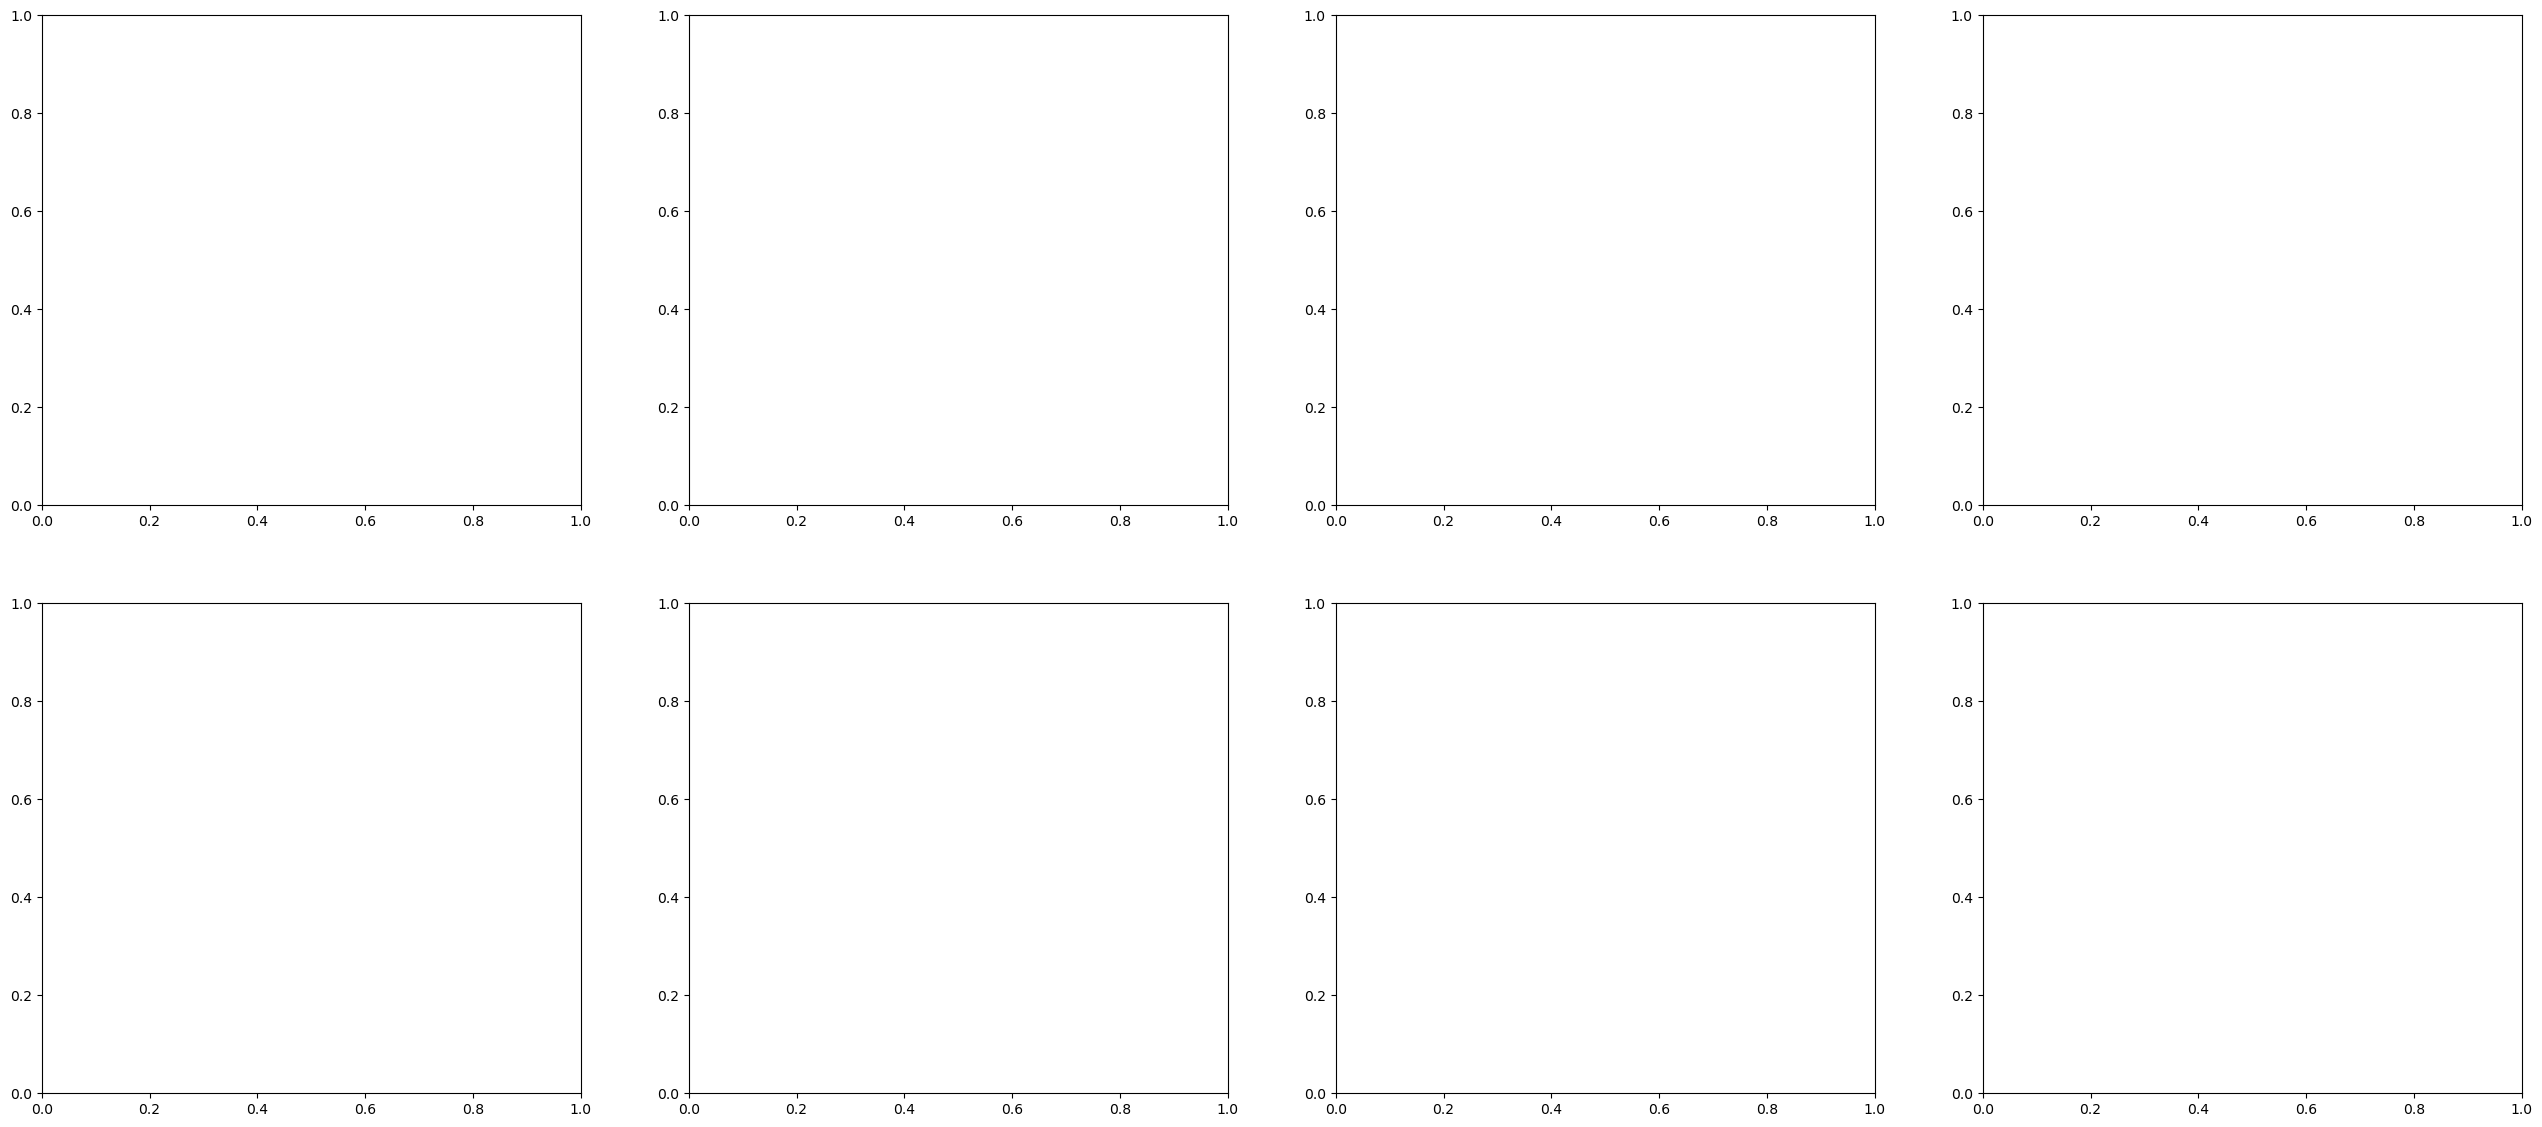

In [13]:
### Start Figure
fig, ax= plt.subplots(2,4,figsize=(32,14))
cwd=''
shelves = ["shelf_400_TP04.nc"]
tos_shelves = []
table_names = []
runmean_len=15

# plot observations
# observation sst
# ESACCI starts at 1980, ends at 2024
file_name = "analysis/observations/ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0_mean_remap_1980-2022_shelf_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"analysed_sst")
var_np = np.squeeze(np.array(var[0:-2]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1980,1980+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst ESA CCI=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_ESACCI = np.zeros(118)
var_sst_ESACCI[-len(var_runmean)::] = var_runmean-np.mean(np.squeeze(var_runmean[0:1]))
print("1975-1985 average SST ESA CCI = ",np.mean(var_np[0:10])-6*var_runmean_trend)

### Read in data
##### SST #####
#plot observations
#observation sst
# NOAA starts at 1981, ends at 2024
file_name = "analysis/observations/sst.an.mean_400coastalocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[0:-3]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1981,1981+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst NOAA=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_NOAA = np.zeros(121)
var_sst_NOAA[-len(var_runmean)::] = var_runmean-np.mean(np.squeeze(var_runmean[0:1]))

#plot observations
### starts 1870, ends 2022
file_name = "analysis/observations/HadISST_sst_annual_0p25res_400mcoastal_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[111::]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1980,1980+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst hadisst=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_hadisst = np.zeros(121)
var_sst_hadisst[-len(var_runmean):] = var_runmean-np.mean(np.squeeze(var_runmean[0:1]))

#plot observations
### starts 1891, ends 2023
file_name = "analysis/observations/cobe_sst.an.mean_0p25_400coastalTS.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[89:-2]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1981,1981+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst cobe=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_cobe = np.zeros(121)
var_sst_cobe[-len(var_runmean):] = var_runmean-np.mean(np.squeeze(var_runmean[0:1]))

var_concat = [var_sst_NOAA,var_sst_hadisst,var_sst_cobe]
var_sst_mean=np.mean(var_concat,axis=0)
var_sst_min=np.min(var_concat,axis=0)
var_sst_max=np.max(var_concat,axis=0)


##### pH #####
#observation hi
file_name = "analysis/observations/hi_coastal_globalTS.nc"
var,time = read_nc_var(cwd,file_name,"htotal")
years = np.arange(1982,1982+len(var))


var_ph_ETH = np.zeros(121)
var_ph_ETH[(-len(var[:])-3):-3] = (np.squeeze(var[:])-np.mean(np.squeeze(var[0:3])))*1E9

#observation hi
file_name = "analysis/observations/dataset-ph-rep_r025-yearly_1985to2021_400shelf_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"ph")
var_np = np.squeeze(10**(-np.array(var[0:37])))
years = np.arange(1982,1982+len(var_np))

var_ph_lse = np.zeros(121)
var_ph_lse[-len(var_np[0:40])-2:-2] = (var_np[0:40]-np.mean(np.squeeze(var_np[0])))*1E9 

var_concat = [var_ph_ETH,var_ph_lse]
var_ph_mean=np.mean(var_concat,axis=0)
var_ph_min=np.min(var_concat,axis=0)
var_ph_max=np.max(var_concat,axis=0)


#observation NPP
file_name = "analysis/observations/vgpm_wgrid_annual_all_0p5res_coastal_total.nc"
var,time = read_nc_var(cwd,file_name,"npp")
var = np.average(var[:].reshape(-1, 19), axis=0)
var = var / (36 * 1E12)
var_runmean =extrapolated_runmean(var,5)
years = np.arange(2003,2003+len(var))
var_runmean_trend,a = np.polyfit(np.arange(0,19), var_runmean, 1)

var_npp_vgpm = np.zeros(117)
var_npp_vgpm[-42-1:-1] = (np.arange(0,42)*var_runmean_trend)


shelves=["shelf_400_TP04.nc"]
count = 0
for shelf in shelves:
    for sim in ["clim","riv"]:
        #NPP
        file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_sum" + ".nc"
        var,time = read_nc_var(cwd,file_name,"NPP")
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)   
        years=np.arange(1905,1905+len(var_plot))
        years_plot=np.arange(1905,1905+len(var_plot))
        sim_prev=sim
        count=count+1

var_npp_model = (var_plot - np.mean(var_plot[75:85]))*1E-15

#observation O2
##### Ito et al. 2019
file_name = "analysis/observations/o2_OI1x1_1967_2012_wod2018_0d25_400coastal_fldmean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"o2")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np * 32 
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1975,1975+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend O2 coastal ocean Ito et al. 2022=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average O2 Ito et al. 2022 = ",np.mean(var_np[0:10]))
var_o2_ito2022 = np.zeros(117)
var_o2_ito2022[-len(var_runmean[:])::] = (np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))

#### Ito et al., 2023
file_name = "analysis/observations/ito2023_remap0p25_shelf_fldmean_vertmean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"o2")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np / 1000 * 32
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1965,1965+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend O2 coastal ocean Ito et al. 2024=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average O2 Ito et al. 2024 = ",np.mean(var_np[10:20]))
var_o2_ito2024 = np.zeros(117)
var_o2_ito2024[-len(var_runmean[:])::] = (np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))

var_concat = [var_o2_ito2024,var_o2_ito2022]
var_oxygen_mean=np.mean(var_concat,axis=0)
var_oxygen_min=np.min(var_concat,axis=0)
var_oxygen_max=np.max(var_concat,axis=0)

#read observations
#define path
cwd=''
shelves = ["shelf_250_TP04.nc"]
# read atmospheric CO2
file_name="analysis/forcings/" + "atmosphericCO2.txt"
data = pd.read_csv(cwd + file_name, names= ["year","CO2","CH4","N2O"],sep="     ")
atmCO2=data[data["year"]<2023]["CO2"]
atmCO2_runmean=extrapolated_runmean(np.squeeze(np.array(atmCO2[:])),15)

# read surface temperature
file_name = "analysis/forcings/" + "ERA_srfT_globalTS_2010.nc"
var,time = read_nc_var(cwd,file_name,"var167")
srf_temp = np.squeeze(var[0:105])
srf_temp_runmean = extrapolated_runmean(np.squeeze(srf_temp),15)

# read river nitrogen
cwd=''
file_name = "analysis/forcings/" + "RiverNInput_globalTS.nc"
var,time = read_nc_var(cwd,file_name,"N_Input")
riv_n = np.squeeze(var[0:110])
riv_n = riv_n * 1E-6
riv_n_runmean = np.zeros(117)
riv_n_runmean[0:110] = extrapolated_runmean(np.squeeze(riv_n),15)
riv_n_runmean[110:117] = riv_n_runmean[109] + (riv_n_runmean[109] - riv_n_runmean[108]) * np.arange(0,7)

for shelf in shelves:
    for sim in ["CO2","clim","riv"]:
        file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_sum" + ".nc"
        var,time = read_nc_var(cwd,file_name,"depto")
        if sim=="CO2":
            NPP_CO2=var
        elif sim=="clim":
            NPP_clim=var
        else:
            NPP_riv=var
var_riv=NPP_riv[:]-pimean(NPP_riv)
NPP_riv_runmean=extrapolated_runmean(np.squeeze(NPP_riv[:]),15) / (36 * 1E12)   

print("River N increment change:",riv_n_runmean[-2]-riv_n_runmean[-3])

In [5]:
shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
colors=["lightskyblue","darkkhaki","darkred"]
count=0
for shelf in shelves:    
    #model sst HAMOCC-RIV
    if shelf == "shelf_400_TP04.nc":
        file_name = "analysis/T/" + shelf + "_T"+".nc"
        var,time = read_nc_var(cwd,file_name,"thetao_anmean")
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years_plot=np.arange(1905,1905+len(var_plot))
        #ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[5:5+len(var_plot)]-np.mean(atmCO2[75:85]),var_plot[:]-np.mean(np.squeeze(var_plot[70:80])),color="darkred",linewidth=3,linestyle="dashed")
    else:
        file_name = "analysis/T/" + shelf + "_T"+".nc"
        var,time = read_nc_var(cwd,file_name,"to")
        var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
        #ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[0:len(var_plot_icon)]-np.mean(atmCO2[75:85]),var_plot_icon[:]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=3,linestyle="dashed")
        ax[0,0].text(0.65,0.12,"R$^2$=0.974",transform=ax[0,0].transAxes,fontsize=26,color="darkred")

#### Get SST timeseries
var_sst_hamocc = np.empty(2011-1900)
var_sst_hamocc[-len(var_plot)-1:-1] = (var_plot[0:]-np.mean(np.squeeze(var_plot[70:80])))
var_runmean_trend,a = np.polyfit(years_plot_icon[75::], var_sst_hamocc[75::], 1)
print("trend sst coastal ocean HAMOCC=",var_runmean_trend*(len(np.arange(1980,2022))))
trend,a = np.polyfit(np.arange(0,len(time[0:75])),np.squeeze(var[0:75]),1)
print("trend sst model coastal HAMOCC 1900-1980=",trend*len(var[0:75]))

var_sst_icon = np.empty(2011-1900)
var_sst_icon[-len(var_plot_icon):] = (var_plot_icon[:]-np.mean(np.squeeze(var_plot_icon[75:85])))
var_runmean_trend,a = np.polyfit(years_plot_icon[75::], var_sst_icon[75::], 1)
print("trend sst coastal ocean ICON=",var_runmean_trend*(len(np.arange(1980,2022))))
trend,a = np.polyfit(np.arange(0,len(time[0:80])),np.squeeze(var_sst_icon[0:80]),1)
print("trend sst model coastal ICON 1900-1980=",trend*len(var[0:80]))

#### Make model SST average
var_concat = [var_sst_hamocc,var_sst_icon]
var_model = np.mean(var_concat,axis=0)
var_model_min = np.min(var_concat,axis=0)
var_model_max = np.max(var_concat,axis=0)
ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[5:110]-np.mean(atmCO2[75:85]),var_model[5:110]-np.mean(np.squeeze(var_model[75:85])),color="darkred",linewidth=5)
ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[5:110]-np.mean(atmCO2[75:85]),var_model_max[5:110]-np.mean(np.squeeze(var_model_max[75:85])),color="darkred",linewidth=3,linestyle="dashed")
ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[5:110]-np.mean(atmCO2[75:85]),var_model_min[5:110]-np.mean(np.squeeze(var_model_min[75:85])),color="darkred",linewidth=3,linestyle="dashed")

        
shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
colors=["lightskyblue","darkkhaki","darkred"]
count=0
shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
count = 0
for shelf in shelves:
    if shelf=="shelf_400_TP04.nc":        
        for sim in ["riv"]:
            file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)  
            years=np.arange(1905,1905+len(var_plot))
            NPP_riv_runmean= np.squeeze(var_plot[:])
            sim_prev=sim
            count=count+1
            
    if shelf=="shelf400m_icon_cl":
        for sim in ["all"]:
            file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_perm2_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"NPP")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)   
            years=np.arange(1900,1900+len(var_plot_icon))
            NPP_riv_runmean_icon = var_plot_icon[:]


#### Get NPP timeseries
var_npp_hamocc = np.empty(2011-1900)
var_npp_hamocc[-len(NPP_riv_runmean)-1:-1] = (NPP_riv_runmean[0::]-np.mean(np.squeeze(NPP_riv_runmean[70:80])))

var_npp_icon = np.empty(2011-1900)
var_npp_icon[-len(NPP_riv_runmean_icon):] = (NPP_riv_runmean_icon[:]-np.mean(np.squeeze(NPP_riv_runmean_icon[75:85])))

#### Make model SST average
var_concat = [var_npp_hamocc,var_npp_icon]
var_model = np.mean(var_concat,axis=0)
var_model_min = np.min(var_concat,axis=0)
var_model_max = np.max(var_concat,axis=0)
ax[0,2].plot(extrapolated_runmean(riv_n_runmean[5:110]-np.mean(riv_n_runmean[75:85]),15),var_model[5:110]-np.mean(np.squeeze(var_model[75:85])),color="darkred",linewidth=5)
ax[0,2].plot(extrapolated_runmean(riv_n_runmean[5:110]-np.mean(riv_n_runmean[75:85]),15),var_model_min[5:110]-np.mean(np.squeeze(var_model_min[75:85])),color="darkred",linewidth=3,linestyle="dashed")
ax[0,2].plot(extrapolated_runmean(riv_n_runmean[5:110]-np.mean(riv_n_runmean[75:85]),15),var_model_max[5:110]-np.mean(np.squeeze(var_model_max[75:85])),color="darkred",linewidth=3,linestyle="dashed")

trend sst coastal ocean HAMOCC= 0.5873291677182902
trend sst model coastal HAMOCC 1900-1980= 0.10840471302971073
trend sst coastal ocean ICON= 0.6737275388219358
trend sst model coastal ICON 1900-1980= 0.09530737170913779


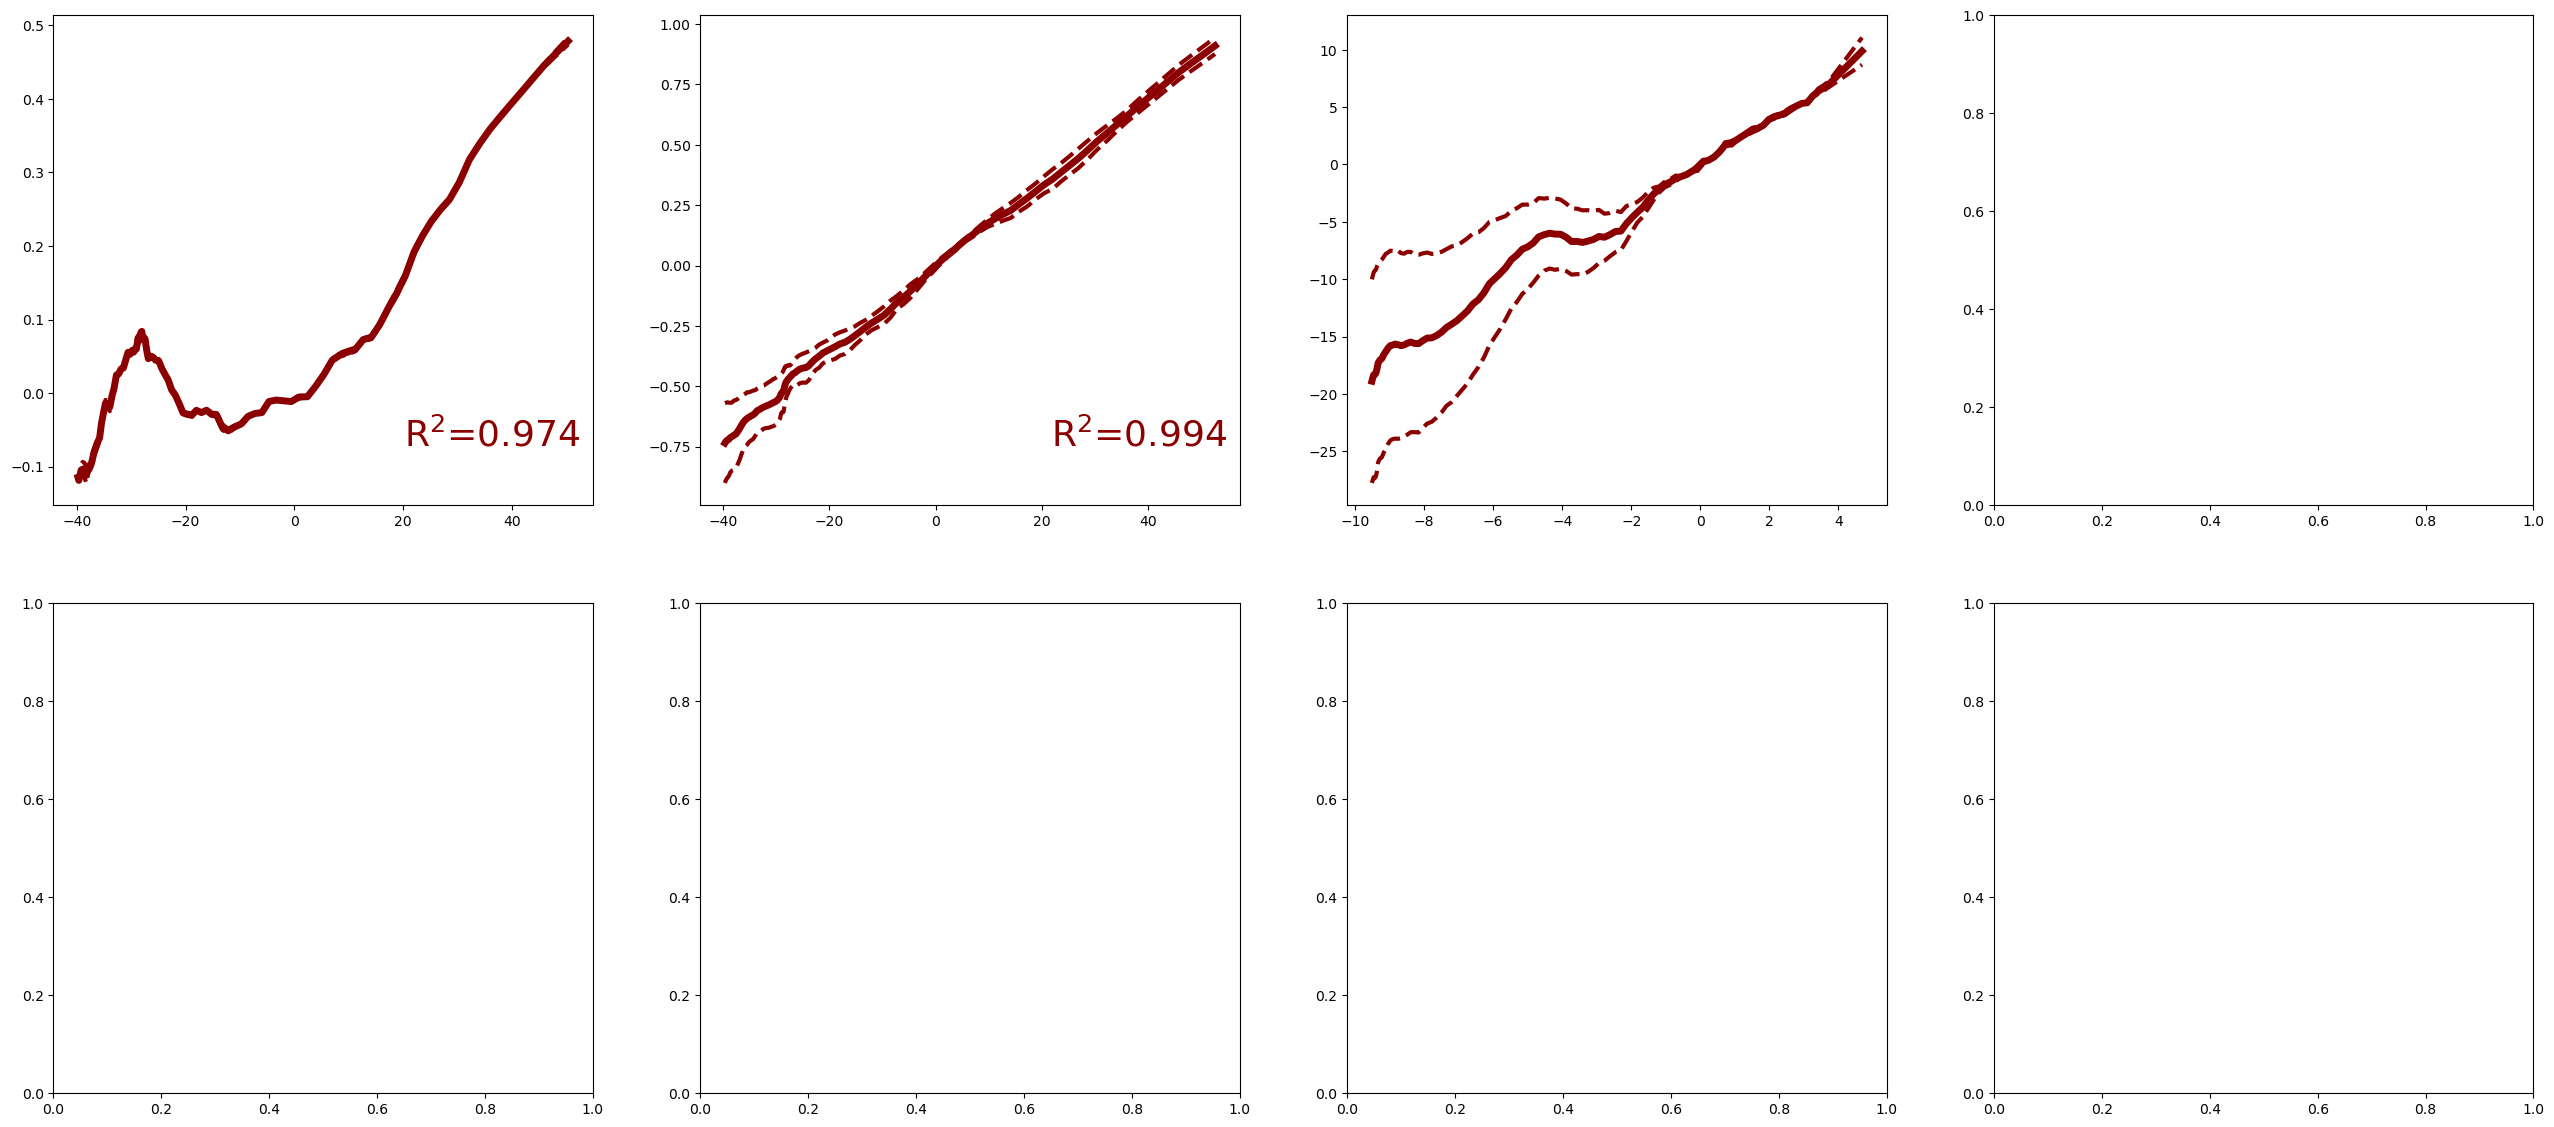

In [6]:
shelves=["shelf_250_TP04.nc","shelf400m_icon_cl"]
colors=["lightskyblue","darkkhaki","darkred"]

count=0
for shelf in shelves:
    if shelf == "shelf_250_TP04.nc":
        for sim in ["CO2","clim","riv"]:
            #ph
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
            years=np.arange(1905,1905+len(var_plot))
            count=count+1
    
    else:
        file_name = "analysis/pH/" + shelf + "_hi_"+ "all" + "_mean" + ".nc"
        var,time = read_nc_var(cwd,file_name,"hi")
        var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years_icon=np.arange(1900,1900+len(var_plot_icon))
        count=count+1
        
        ax[0,1].text(0.65,0.12,"R$^2$=0.994",transform=ax[0,1].transAxes,fontsize=26,color="darkred")

        
### Put together model variables for averages/mins/maxs           
var_ph_hamocc = np.empty(2011-1900)
var_ph_hamocc[-len(var_plot)::] = (var_plot[0::]-np.mean(np.squeeze(var_plot[70:80])))*1E9
var_ph_icon = np.empty(2011-1900)
var_ph_icon[-len(var_plot_icon):] = (var_plot_icon[0::]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9

### Calculate model mean/mins/maxs   
var_concat = [var_ph_hamocc,var_ph_icon]
ph_model_mean = np.mean(var_concat,axis=0)
ph_model_min = np.min(var_concat,axis=0)
ph_model_max = np.max(var_concat,axis=0)

### Plot model mean/mins/maxs  
ax[0,1].plot(extrapolated_runmean(np.array(atmCO2),15)[6:111]-np.mean(atmCO2[75:85]),(np.squeeze(ph_model_mean[6::])-np.mean(ph_model_mean[75:85])),color="darkred",linewidth=5)
ax[0,1].plot(extrapolated_runmean(np.array(atmCO2),15)[6:111]-np.mean(atmCO2[75:85]),(np.squeeze(ph_model_min[6::])-np.mean(ph_model_mean[75:85])),color="darkred",linewidth=3,linestyle="dashed")
ax[0,1].plot(extrapolated_runmean(np.array(atmCO2),15)[6:111]-np.mean(atmCO2[75:85]),(np.squeeze(ph_model_max[6::])-np.mean(ph_model_mean[75:85])),color="darkred",linewidth=3,linestyle="dashed")
fig

In [7]:
#### Get oxygen model timeseries

shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
count=0
for shelf in shelves:
    count=0
    if shelf=="shelf_400_TP04.nc":        
        #pH
        #for sim in ["clim","riv"]:
        for sim in ["riv"]:
            #Oxygen
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_runmean=extrapolated_runmean(np.squeeze(var[:]),runmean_len) 
            var_plot=extrapolate_until_2020_drivers(np.squeeze(var_runmean[:]),"O2",var_drivers,trend_drivers)         
            years_plot=np.arange(1905,1905+len(var_plot))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            var_runmean_trend,a = np.polyfit(years_plot[75::], var_plot[75::], 1)
            print("trend O2 coastal HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2022))))
            print("1975-1985 coastal average O2 HAMOCC = ",np.mean(var_plot[70:80])*32)
            count=count+1
    if shelf=="shelf400m_icon_cl":
        #for sim in ["co2_clim","all"]:
        for sim in ["all"]:
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"o2")
            var_runmean_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
            var_plot_icon=extrapolate_until_2020_drivers(np.squeeze(var_runmean_icon[:]),"O2",var_drivers,trend_drivers)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
            var_runmean_trend,a = np.polyfit(years_plot_icon[75:-2], var_plot_icon[75:-2], 1)
            var_runmean_trend,a = np.polyfit(years_plot_icon[75::], var_plot_icon[75::], 1)
            print("trend O2 coastal ICON {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2022))))
            print("1975-1985 coastal average O2 ICON = ",np.mean(var_plot_icon[75:85])*32)
            count=count+1
            
#### Get O2 timeseries
var_oxygen_hamocc = np.empty(2022-1900)
var_oxygen_hamocc[-len(var_plot):] = (var_plot[0:]-np.mean(np.squeeze(var_plot[70:80])))

var_oxygen_icon = np.empty(2022-1900)
var_oxygen_icon[-len(var_plot_icon):] = (var_plot_icon[:-2]-np.mean(np.squeeze(var_plot_icon[75:85])))

#### Make model oxygen mean/min/max
var_concat = [var_oxygen_hamocc,var_oxygen_icon]
var_model = np.mean(var_concat,axis=0)
var_model_min = np.min(var_concat,axis=0)
var_model_max = np.max(var_concat,axis=0)

### Plot model oxygen mean/min/max
ax[0,3].plot(extrapolated_runmean(np.array(atmCO2),15)[5::]-np.mean(atmCO2[75:85]),var_model[5::]-np.mean(np.squeeze(var_model[75:85])),color="darkred",linewidth=5)
ax[0,3].plot(extrapolated_runmean(np.array(atmCO2),15)[5::]-np.mean(atmCO2[75:85]),var_model_min[5::]-np.mean(np.squeeze(var_model_max[75:85])),color="darkred",linewidth=3,linestyle="dashed")
ax[0,3].plot(extrapolated_runmean(np.array(atmCO2),15)[5::]-np.mean(atmCO2[75:85]),var_model_max[5::]-np.mean(np.squeeze(var_model_max[75:85])),color="darkred",linewidth=3,linestyle="dashed")              

[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend O2 coastal HAMOCC riv= -0.03879330006143648
1975-1985 coastal average O2 HAMOCC =  288.9869840494792
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend O2 coastal ICON all= -0.07767315283328138
1975-1985 coastal average O2 ICON =  264.5841739908854


/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_9747/3393724622.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_9747/3393724622.py:57: UserWarning: The handle <matplotlib.lines.Line2D object at 0x13c790040> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax[0,0].legend(["Observation mean","Observation stand. dev.","_nolegend_","Model mean","Model stand. dev."],fontsize=16)


[286.74865143 286.77337942 286.81243921 286.84119549 286.87127067
 286.89580529 286.92033991 286.94487453 286.96940915 286.99394377
 287.0184784  287.04301302]


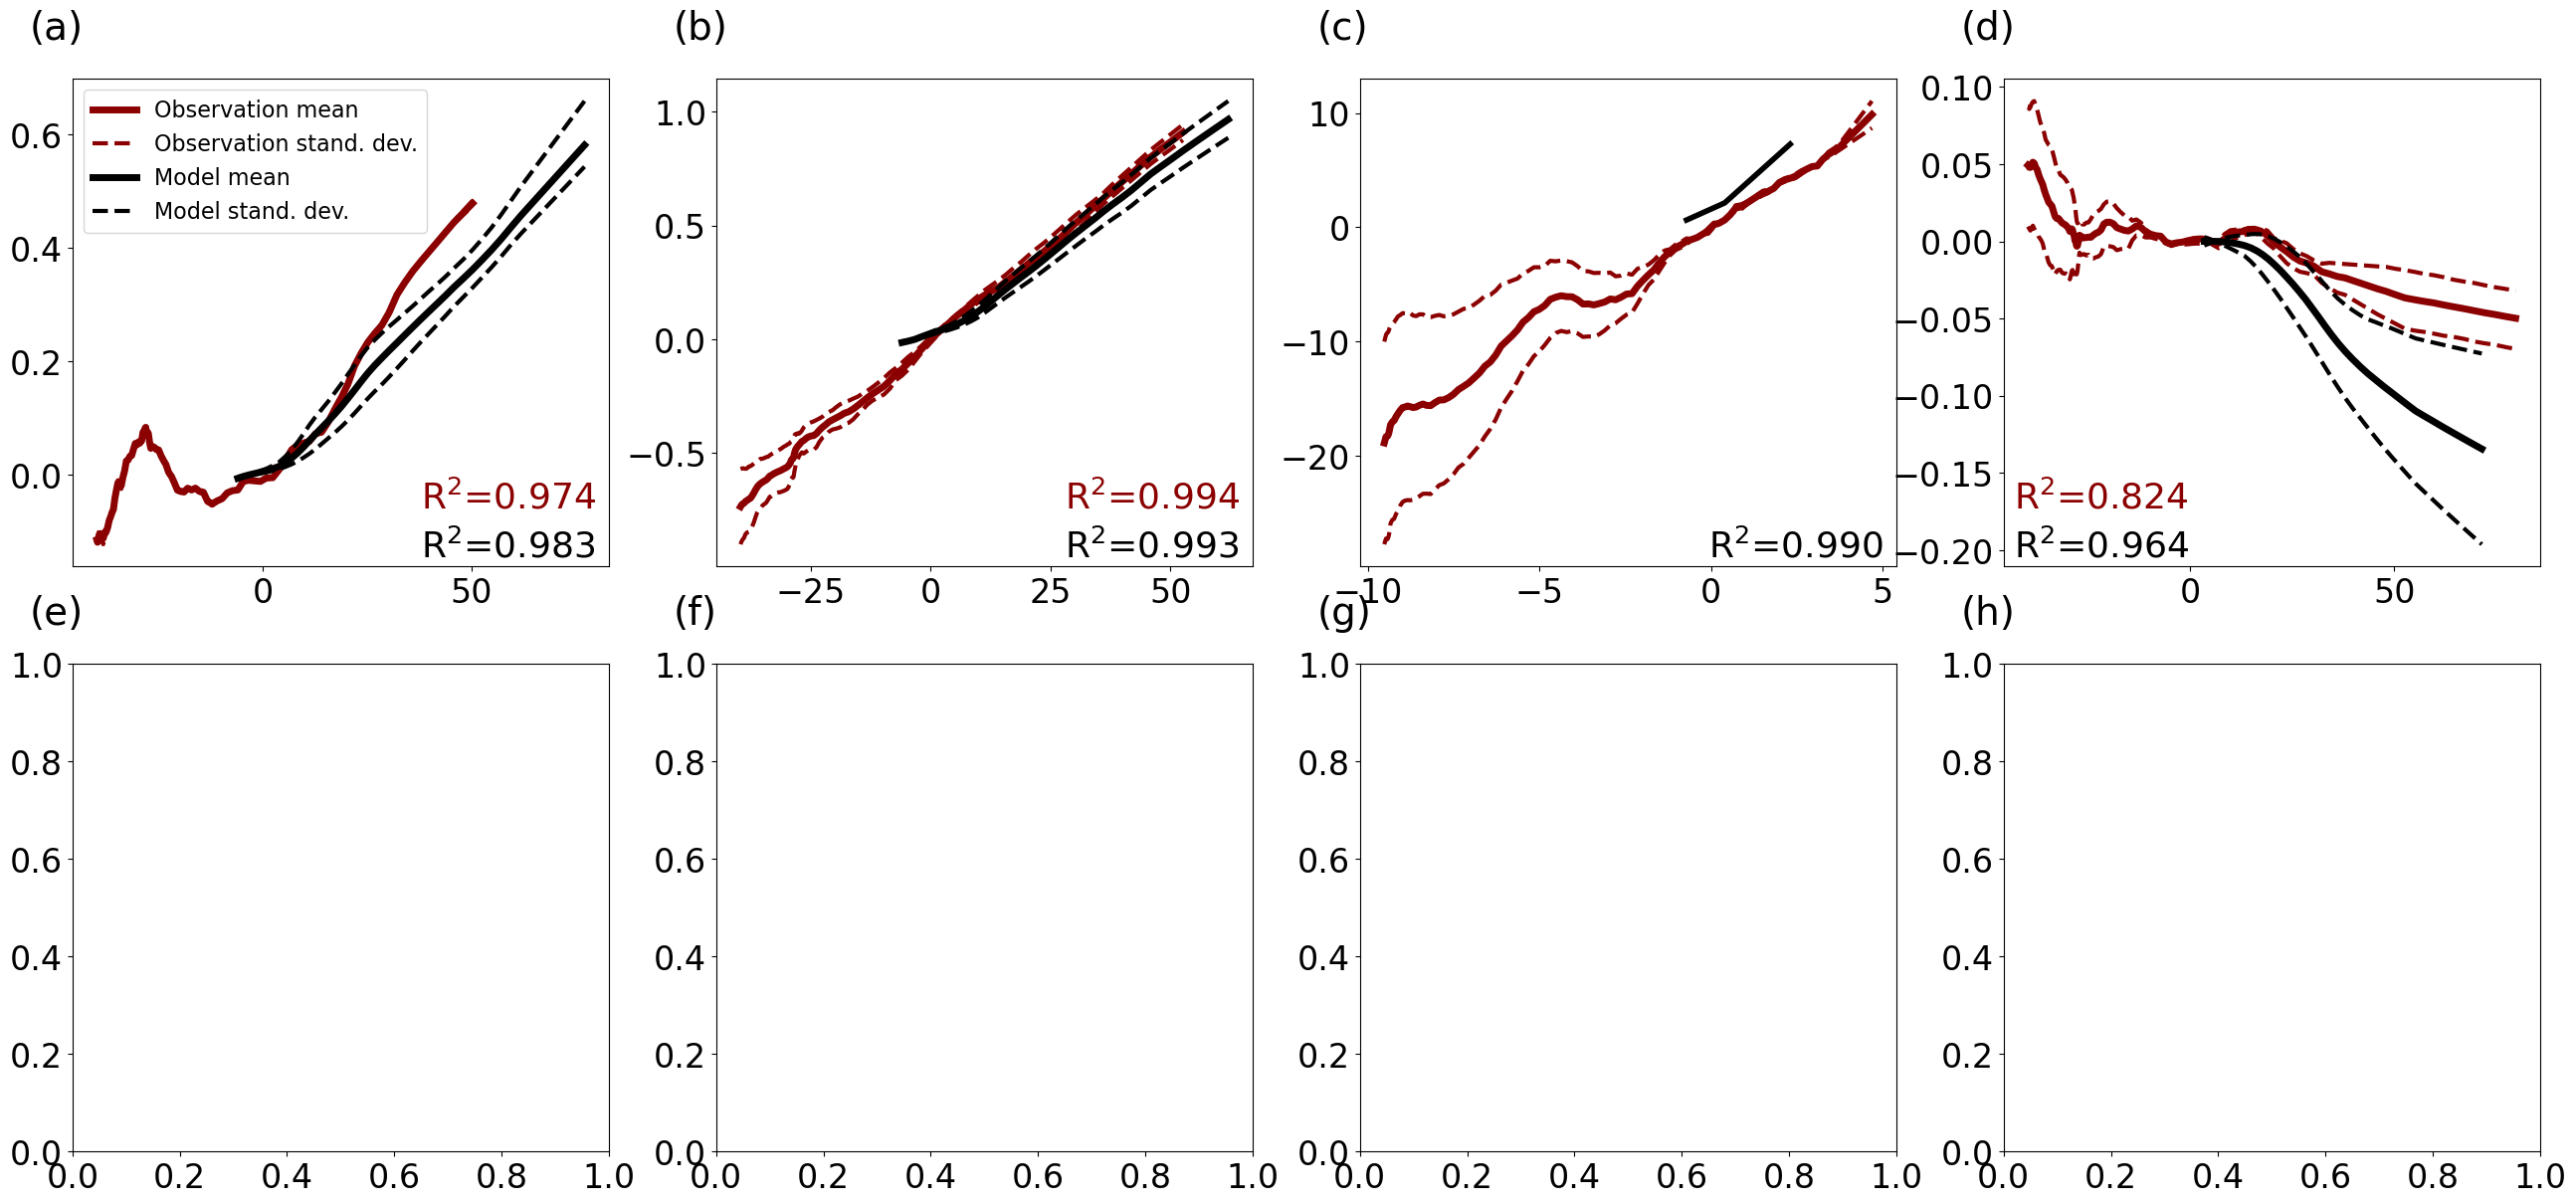

In [8]:

fig.show()    
        
#plot observations
#observation sst8
file_name = "analysis/observations/sst_coastal_globalTS.nc"
var,time = read_nc_var(cwd,file_name,"sst")

####Plot observational mean, maximum, minimum
ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[75:121]-np.mean(atmCO2[75:85]),
             extrapolated_runmean(np.squeeze(var_sst_mean[75:121]),15)-np.mean(np.squeeze(var_sst_mean[75:85])),color="black",linewidth=5)
ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[75:121]-np.mean(atmCO2[75:85]),
             extrapolated_runmean(np.squeeze(var_sst_max[75:121]),15)-np.mean(np.squeeze(var_sst_max[75:85])),color="black",linewidth=3,linestyle="dashed")
ax[0,0].plot(extrapolated_runmean(np.array(atmCO2),15)[75:121]-np.mean(atmCO2[75:85]),
             extrapolated_runmean(np.squeeze(var_sst_min[75:121]),15)-np.mean(np.squeeze(var_sst_min[75:85])),color="black",linewidth=3,linestyle="dashed")

# add correlation value to plot
#cor=np.corrcoef(extrapolate_until_2000(srf_temp_runmean,1905,years)[75:121],extrapolated_runmean(np.squeeze(var_sst_mean[75:121]),15))
ax[0,0].text(0.65,0.02,"R$^2$=0.983",transform=ax[0,0].transAxes,fontsize=26,color="black",)

#observation hi, plot observational mean, maximum, minimum
ax[0,1].plot(extrapolated_runmean(np.array(atmCO2),15)[75:115]-np.mean(atmCO2[75:85]),
             extrapolated_runmean(np.squeeze(var_ph_mean[75:115]),15)-np.mean(np.squeeze(var_ph_mean[75:85])),
             color="black",linewidth=5) 
ax[0,1].plot(extrapolated_runmean(np.array(atmCO2),15)[75:115]-np.mean(atmCO2[75:85]),
             extrapolated_runmean(np.squeeze(var_ph_min[75:115]),15)-np.mean(np.squeeze(var_ph_min[75:85])),
             color="black",linewidth=3,linestyle="dashed") 
ax[0,1].plot(extrapolated_runmean(np.array(atmCO2),15)[75:115]-np.mean(atmCO2[75:85]),
             extrapolated_runmean(np.squeeze(var_ph_max[75:115]),15)-np.mean(np.squeeze(var_ph_max[75:85])),
             color="black",linewidth=3,linestyle="dashed") 
# add correlation value to plot
cor=np.corrcoef(extrapolated_runmean(np.array(atmCO2),15)[75:115],extrapolated_runmean(np.squeeze(var_ph_mean[75:115]),15))
ax[0,1].text(0.65,0.02,"R$^2$=0.993",transform=ax[0,1].transAxes,fontsize=26,color="black",)

#observation n
ax[0,2].plot(riv_n_runmean[85:105]-np.mean(riv_n_runmean[85:95]),
             extrapolated_runmean(np.squeeze(var_npp_vgpm[85:105]),5)-np.mean(np.squeeze(var_npp_vgpm[85:90])),
             color="black",linewidth=4) 
# add correlation value to plot
cor=np.corrcoef(riv_n_runmean[85:105],extrapolated_runmean(np.squeeze(var_npp_vgpm[85:105]),5))
ax[0,2].text(0.65,0.02,"R$^2$=0.990",transform=ax[0,2].transAxes,fontsize=26,color="black")

#observation o2
ax[0,3].plot(extrapolated_runmean(np.array(atmCO2),15)[75:115]-np.mean(atmCO2[68:78]),
             extrapolated_runmean(np.squeeze(var_oxygen_mean[75:115]),15)-np.mean(np.squeeze(var_oxygen_mean[75:85])),
             color="black",linewidth=5) 
ax[0,3].plot(extrapolated_runmean(np.array(atmCO2),15)[75:115]-np.mean(atmCO2[68:78]),
             extrapolated_runmean(np.squeeze(var_oxygen_min[75:115]),15)-np.mean(np.squeeze(var_oxygen_min[75:85])),
             color="black",linewidth=3,linestyle="dashed") 
ax[0,3].plot(extrapolated_runmean(np.array(atmCO2),15)[75:115]-np.mean(atmCO2[68:78]),
             extrapolated_runmean(np.squeeze(var_oxygen_max[75:115]),15)-np.mean(np.squeeze(var_oxygen_max[75:85])),
             color="black",linewidth=3,linestyle="dashed") 

cor=np.corrcoef(extrapolate_until_2000(srf_temp_runmean,1905,years)[75:115],extrapolated_runmean(np.squeeze(var_oxygen_mean[75:115]),15))
ax[0,3].text(0.02,0.02,"R$^2$=0.964",transform=ax[0,3].transAxes,fontsize=26,color="black")
ax[0,3].text(0.02,0.12,"R$^2$=0.824",transform=ax[0,3].transAxes,fontsize=26,color="darkred")

ax[0,0].legend(["Observation mean","Observation stand. dev.","_nolegend_","Model mean","Model stand. dev."],fontsize=16)

fig

#Number subplots
alphabet =["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)","(j)","(k)","(l)","(m)","(n)"]
count = 0
for axe in ax.reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=24)
    title_pos =axe.title.get_position()
    axe.annotate(alphabet[count],
                xy=([title_pos[0]-0.58,title_pos[1]+0.08]), xytext=(0, 0.5), 
                xycoords=('axes fraction', 'axes fraction'),
                textcoords='offset points',size=28)
    count = count + 1
    
    
### SST

#ax[1,0].set_title("SST [°C]",fontsize=30,pad=16)
#ax[1,0].set_xlabel("Atmospheric CO$_{2}$ [ppm]",fontsize=26)

### acidity

#ax[1,1].set_title("H$^{+}$ [M]",fontsize=30,pad=16)
#ax[1,1].set_xlabel("Atmospheric CO$_{2}$ [ppm]",fontsize=26)

### NPP 
#ax[1,2].set_title("NPP [g m$^{-2}$ yr$^{-1}}$]",fontsize=30,pad=16)
#ax[1,2].set_xlabel("River N [Mg N yr$^{-1}$]",fontsize=26)


### O2
#ax[1,3].set_title("O$_{2}$ [mg O$_{2}$ L$^{-1}$]",fontsize=26)
#ax[1,3].set_xlabel("Atmospheric CO$_{2}$ [ppm]",fontsize=26)


#fig.savefig("figures/tcre.png",dpi=400,bbox_inches="tight")
fig

In [9]:
### Start separate Figure Future projections
#fig, ax =  plt.subplots(1,4,figsize=(32,7))


### Data SSP projections
sst_data = {"ssp1_median":0.22,"ssp1_min":0.19,"ssp1_max":0.24,
            "ssp2_median":1.41,"ssp2_min":1.25,"ssp2_max":1.60,
              "ssp3_median":2.03,"ssp3_max":2.30,"ssp3_min":1.80,"ssp4_median":1.95,
            "ssp4_max":2.21,"ssp4_min":1.72,"ssp5_median":5.71,"ssp5_max":6.47,"ssp5_min":5.05}

hi_data = {"ssp1_median":0.44,"ssp1_min":0.39,"ssp1_max":0.46,
            "ssp2_median":2.89,"ssp2_min":2.58,"ssp2_max":3.00,
              "ssp3_median":4.16,"ssp3_max":4.33,"ssp3_min":3.73,"ssp4_median":3.99,
            "ssp4_max":4.14,"ssp4_min":3.57,"ssp5_median":11.69,"ssp5_max":12.14,"ssp5_min":10.46}

npp_data = {"ssp1_median":3.18,"ssp1_min":1.97,"ssp1_max":4.12,
            "ssp2_median":20.67,"ssp2_min":12.80,"ssp2_max":26.22,
              "ssp3_median":28.62,"ssp3_max":36.32,"ssp3_min":17.72,"ssp4_median":23.85,
            "ssp4_max":30.26,"ssp4_min":17.72,"ssp5_median":20.67,"ssp5_max":26.22,"ssp5_min":12.80}

oxygen_data = {"ssp1_median":0.032,"ssp1_min":0.008,"ssp1_max":0.072,
            "ssp2_median":0.21,"ssp2_min":0.05,"ssp2_max":0.47,
              "ssp3_median":0.30,"ssp3_max":0.68,"ssp3_min":0.07,"ssp4_median":0.29,
            "ssp4_max":0.65,"ssp4_min":0.07,"ssp5_median":0.86,"ssp5_max":1.91,"ssp5_min":0.21}

### Some things needed for later
eco_vars_data = [sst_data,hi_data,npp_data,oxygen_data]
colors = {"ssp1":"lightgrey", "ssp2":"lightblue","ssp3":"blue","ssp4":"orange","ssp5":"red"}
x_pos_ssp = {"ssp1":0.75, "ssp2":0.85,"ssp3":0.95,"ssp4":1.05,"ssp5":1.05}
scenarios = ["ssp1","ssp2","ssp3","ssp5"]

count = 0
for var in eco_vars_data:
    for scenario in scenarios:
        print(scenario)
        ax[1,count].plot([x_pos_ssp[scenario],x_pos_ssp[scenario]],[var["{}_min".format(scenario)],var["{}_max".format(scenario)]],
                         linewidth=35,color=colors[scenario],alpha=0.4)
        ax[1,count].plot([x_pos_ssp[scenario]-0.02,x_pos_ssp[scenario]+0.02],[var["{}_median".format(scenario)],var["{}_median".format(scenario)]],
                        linewidth=6,color=colors[scenario])
    count = count + 1

ssp1
ssp2
ssp3
ssp5
ssp1
ssp2
ssp3
ssp5
ssp1
ssp2
ssp3
ssp5
ssp1
ssp2
ssp3
ssp5


In [10]:
### SST
ax[1,0].set_xlim([0.7,1.1])
ax[1,0].set_ylim([0,8])
ax[0,0].set_title("SST [°C]",fontsize=30,pad=16)
ax[0,0].set_xlabel("Atmospheric CO$_{2}$ [ppm]",fontsize=26)

### acidity
ax[1,1].set_xlim([0.7,1.1])
ax[1,1].set_ylim([0,15])
ax[0,1].set_title("H$^{+}$ [M]",fontsize=30,pad=16)
ax[0,1].set_xlabel("Atmospheric CO$_{2}$ [ppm]",fontsize=26)

### NPP 
ax[0,2].set_title("NPP [g m$^{-2}$ yr$^{-1}}$]",fontsize=30,pad=16)
ax[0,2].set_xlabel("River N [Mg N yr$^{-1}$]",fontsize=26)
ax[1,2].set_ylim([0,40])
ax[1,2].set_xlim([0.7,1.1])

### O2
ax[0,3].set_title("O$_{2}$ [mg O$_{2}$ L$^{-1}$]",fontsize=26)
ax[0,3].set_xlabel("Atmospheric CO$_{2}$ [ppm]",fontsize=26)
ax[1,3].set_ylim([0,3])
ax[1,3].set_xlim([0.7,1.1])

#### Add legend through proxy
colors_label={"SSP126":"lightgrey","SSP245":"lightblue","SSP370":"blue","SSP585":"red"}
labels = list(colors_label.keys())

handles = [plt.Rectangle((0,0),1,1, color=colors_label[label]) for label in labels]
ax[1,0].legend(handles, labels,fontsize=17,loc="upper left")

ax[1,3].set_yticklabels(["0.0","0.5","1.0","1.5","2.0","2.5","3.0"])

for axe in ax[1,0:4].reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=15,bottom=False,labelbottom=False)

#Number subplots
alphabet =["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)","(i)","(j)","(k)","(l)","(m)","(n)"]
count = 0
for axe in ax.reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=24)
    title_pos =axe.title.get_position()
    axe.annotate(alphabet[count],
                xy=([title_pos[0]-0.58,title_pos[1]+0.08]), xytext=(0, 0.5), 
                xycoords=('axes fraction', 'axes fraction'),
                textcoords='offset points',size=28)
    count = count + 1
    
fig.savefig("figures/tcre_SSP_projections.png",dpi=400)

/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_9747/3994288624.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,3].set_yticklabels(["0.0","0.5","1.0","1.5","2.0","2.5","3.0"])


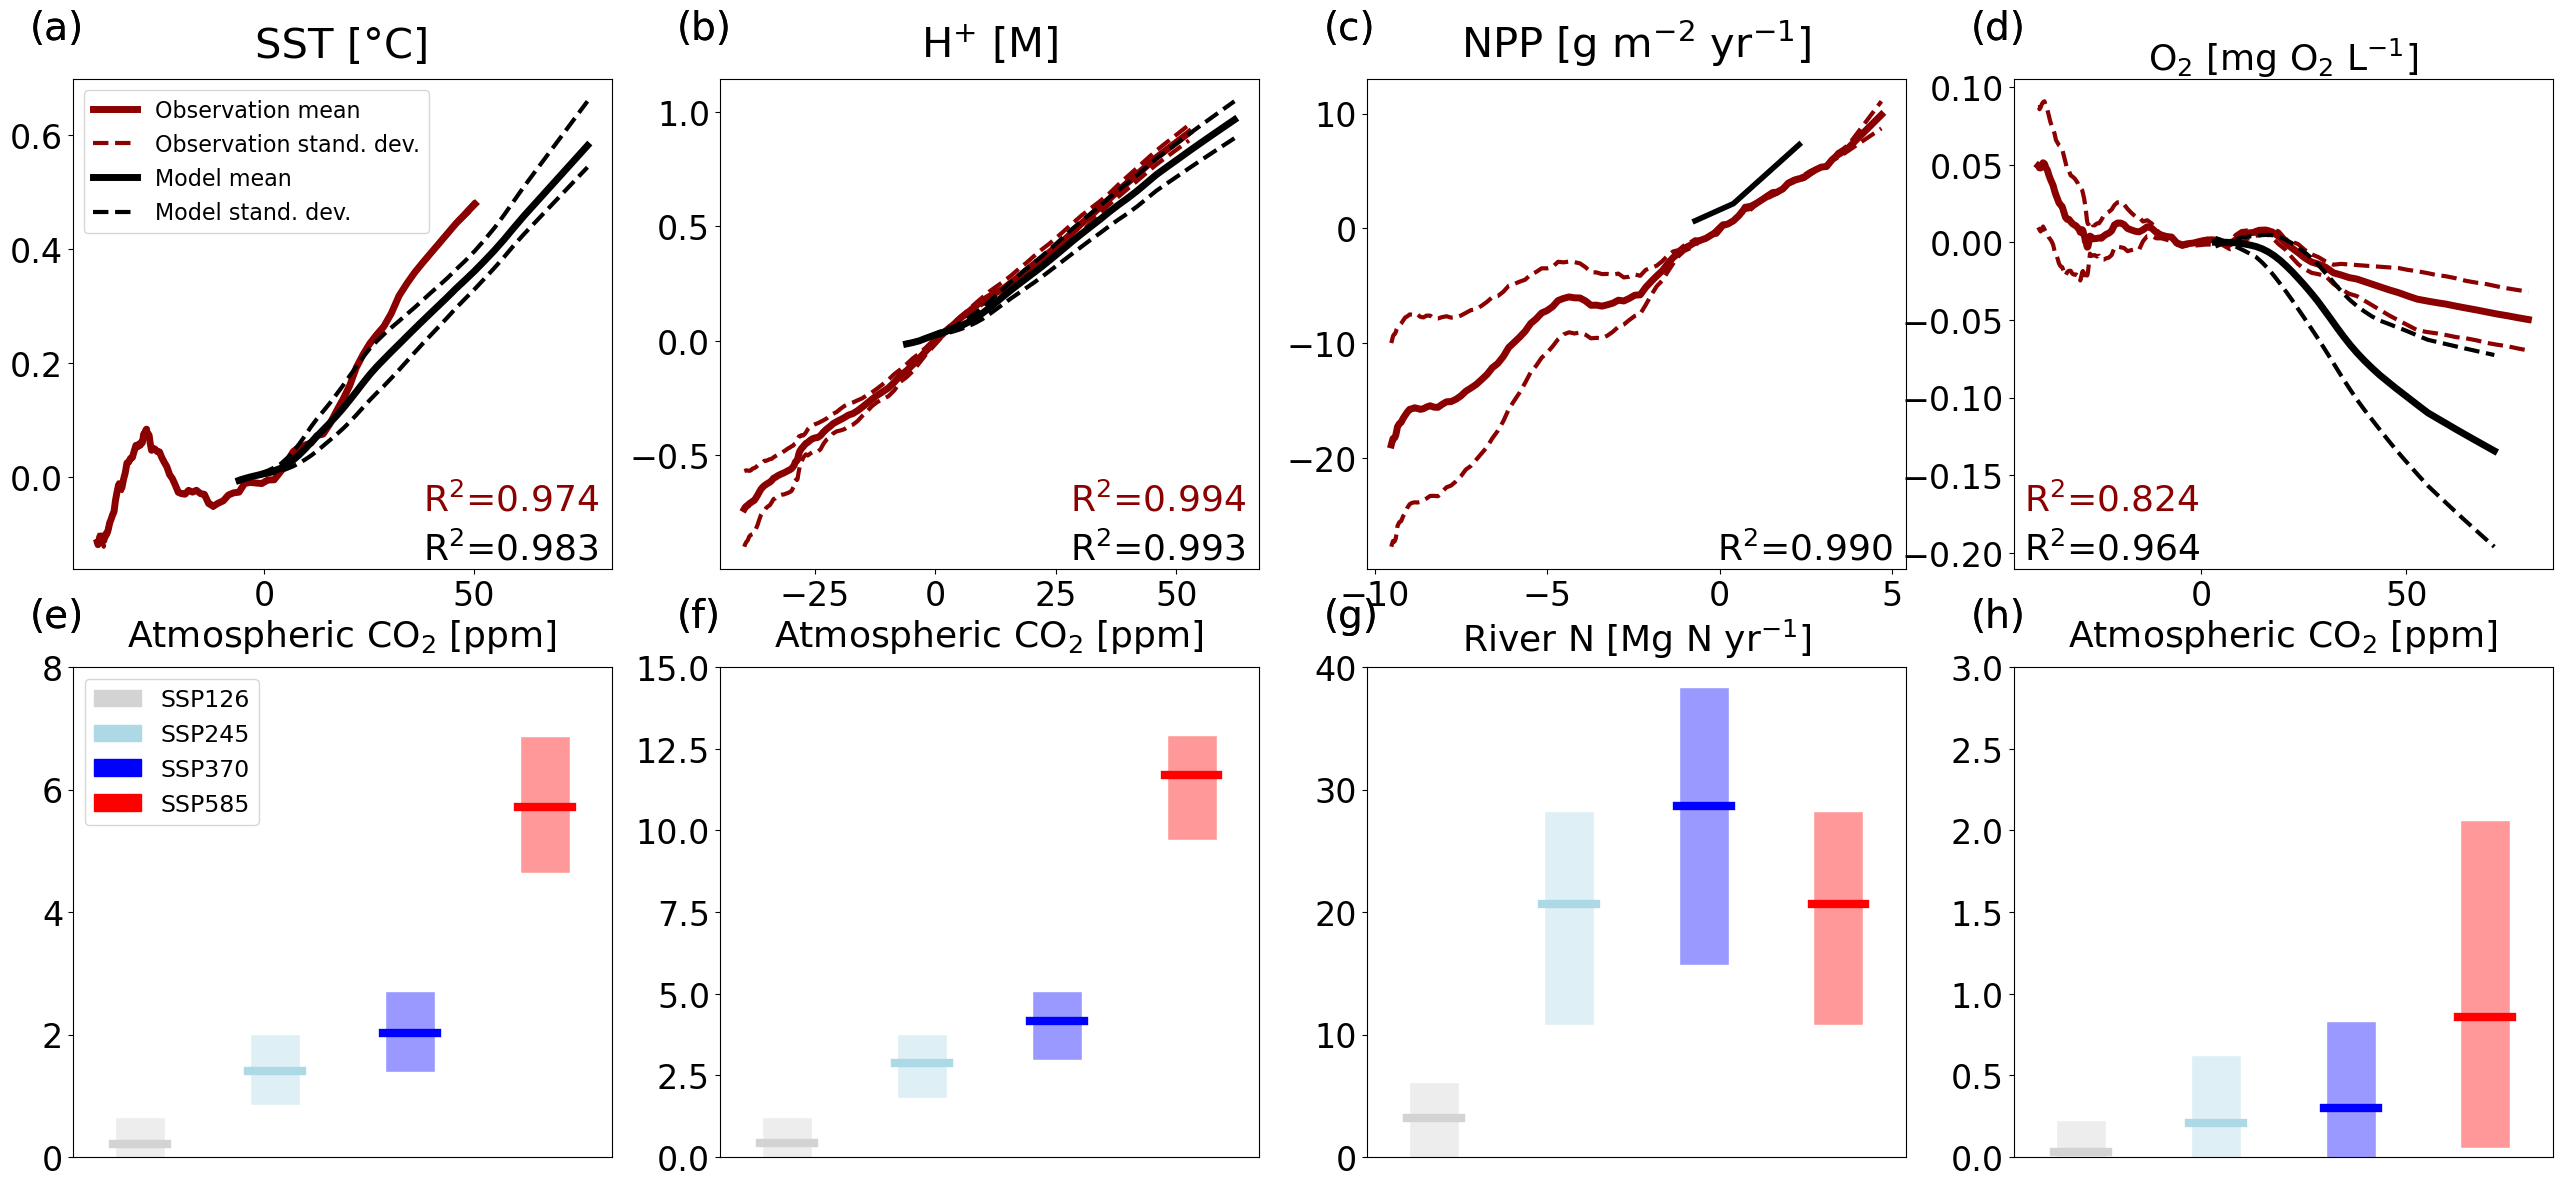

In [11]:
fig

In [17]:
print("SST Correlations Values")
print("-----------------------------------------------------------")
print("trend SST ESA:",stats.linregress(np.array(atmCO2)[75:122],
                                         extrapolated_runmean(np.squeeze(var_sst_ESACCI[70:117]),15)).slope)
print("trend SST NOAA:",stats.linregress(np.array(atmCO2)[75:121],
                                         extrapolated_runmean(np.squeeze(var_sst_NOAA[75:121]),15)).slope)
print("trend SST hadiSST:",stats.linregress(np.array(atmCO2)[75:121],
                                            extrapolated_runmean(np.squeeze(var_sst_hadisst[75:121]),15)).slope)
print("trend SST COBE:",stats.linregress(np.array(atmCO2)[75:121],
                                         extrapolated_runmean(np.squeeze(var_sst_cobe[75:121]),15)).slope)
print("trend SST HAMOCC:",stats.linregress(np.array(atmCO2)[75:111],
                                           extrapolated_runmean(np.squeeze(var_sst_hamocc[75:111]),15)).slope)
print("trend SST ICON:",stats.linregress(np.array(atmCO2)[75:111],
                                         extrapolated_runmean(np.squeeze(var_sst_icon[75:111]),15)).slope)
print("-----------------------------------------------------------")
print("R2 SST ESA:",(stats.linregress(np.array(atmCO2)[75:122],
                                         extrapolated_runmean(np.squeeze(var_sst_ESACCI[70:117]),15)).rvalue)**2)
print("R2 NOAA:",np.square(stats.linregress(np.array(atmCO2)[75:121],
                                            extrapolated_runmean(np.squeeze(var_sst_NOAA[75:121]),15)).rvalue))
print("R2 hadiSST:",np.square(stats.linregress(np.array(atmCO2)[75:121],
                                               extrapolated_runmean(np.squeeze(var_sst_hadisst[75:121]),15)).rvalue))
print("R2 COBE:",np.square(stats.linregress(np.array(atmCO2)[75:121],
                                            extrapolated_runmean(np.squeeze(var_sst_cobe[75:121]),15)).rvalue))
print("R2 HAMOCC:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                              extrapolated_runmean(np.squeeze(var_sst_hamocc[75:111]),15)).rvalue))
print("R2 ICON:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                            extrapolated_runmean(np.squeeze(var_sst_icon[75:111]),15)).rvalue))
print("-----------------------------------------------------------")
print("p value SST ESA:",stats.linregress(np.array(atmCO2)[75:122],
                                         extrapolated_runmean(np.squeeze(var_sst_ESACCI[70:117]),15)).pvalue)
print("trend SST NOAA:",stats.linregress(np.array(atmCO2)[75:121],
                                         extrapolated_runmean(np.squeeze(var_sst_NOAA[75:121]),15)).pvalue)
print("trend SST hadiSST:",stats.linregress(np.array(atmCO2)[75:121],
                                            extrapolated_runmean(np.squeeze(var_sst_hadisst[75:121]),15)).pvalue)
print("trend SST COBE:",stats.linregress(np.array(atmCO2)[75:121],
                                         extrapolated_runmean(np.squeeze(var_sst_cobe[75:121]),15)).pvalue)
print("trend SST HAMOCC:",stats.linregress(np.array(atmCO2)[75:111],
                                           extrapolated_runmean(np.squeeze(var_sst_hamocc[75:111]),15)).pvalue)
print("trend SST ICON:",stats.linregress(np.array(atmCO2)[75:111],
                                         extrapolated_runmean(np.squeeze(var_sst_icon[75:111]),15)).pvalue)
print("-----------------------------------------------------------")
print("-----------------------------------------------------------")

print("pH Correlations Values")
print("-----------------------------------------------------------")
print("trend pH ETH",stats.linregress(np.array(atmCO2)[75:118],
                                      extrapolated_runmean(np.squeeze(var_ph_ETH[75:118]),15)).slope)
print("trend pH LSE",stats.linregress(np.array(atmCO2)[75:119],
                                      extrapolated_runmean(np.squeeze(var_ph_lse[75:119]),15)).slope)
print("trend pH HAMOCC:",stats.linregress(np.array(atmCO2)[75:111],
                                          extrapolated_runmean(np.squeeze(var_ph_hamocc[75:111]),15)).slope)
print("trend pH ICON:",stats.linregress(np.array(atmCO2)[75:111],
                                        extrapolated_runmean(np.squeeze(var_ph_icon[75:111]),15)).slope)
print("-----------------------------------------------------------")
print("R2 pH ETH",np.square(stats.linregress(np.array(atmCO2)[75:118],
                                             extrapolated_runmean(np.squeeze(var_ph_ETH[75:118]),15)).rvalue))
print("R2 pH LSE",np.square(stats.linregress(np.array(atmCO2)[75:119],
                                             extrapolated_runmean(np.squeeze(var_ph_lse[75:119]),15)).rvalue))
print("R2 pH HAMOCC:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                                 extrapolated_runmean(np.squeeze(var_ph_hamocc[75:111]),15)).rvalue))
print("R2 pH ICON:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                               extrapolated_runmean(np.squeeze(var_ph_icon[75:111]),15)).rvalue))
print("-----------------------------------------------------------")
print("P Value pH ETH",np.square(stats.linregress(np.array(atmCO2)[75:118],
                                             extrapolated_runmean(np.squeeze(var_ph_ETH[75:118]),15)).pvalue))
print("P Value LSE",np.square(stats.linregress(np.array(atmCO2)[75:119],
                                             extrapolated_runmean(np.squeeze(var_ph_lse[75:119]),15)).pvalue))
print("P Value pH HAMOCC:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                                 extrapolated_runmean(np.squeeze(var_ph_hamocc[75:111]),15)).pvalue))
print("P Value pH ICON:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                               extrapolated_runmean(np.squeeze(var_ph_icon[75:111]),15)).pvalue))
print("-----------------------------------------------------------")
print("-----------------------------------------------------------")

print("NPP Correlations Values")
print("-----------------------------------------------------------")
print("trend NPP VGPM",stats.linregress(np.array(riv_n_runmean)[68:117],
                                        extrapolated_runmean(np.squeeze(var_npp_vgpm)[68:117],15)).slope)
print("trend NPP HAMOCC:",stats.linregress(np.array(riv_n_runmean)[70:105],
                                          extrapolated_runmean(np.squeeze(var_npp_hamocc[75:110]),15)).slope)
print("trend NPP ICON:",stats.linregress(np.array(riv_n_runmean)[70:105],
                                        extrapolated_runmean(np.squeeze(var_npp_icon[75:110]),15)).slope)
print("-----------------------------------------------------------")
print("R2 NPP VGPM",np.square(stats.linregress(np.array(riv_n_runmean)[68:117],
                                               extrapolated_runmean(np.squeeze(var_npp_vgpm)[68:117],15)).rvalue))
print("R2 NPP HAMOCC:",np.square(stats.linregress(np.array(riv_n_runmean)[70:105],
                                                 extrapolated_runmean(np.squeeze(var_npp_hamocc[75:110]),15)).rvalue))
print("R2 NPP ICON:",np.square(stats.linregress(np.array(riv_n_runmean)[70:105],
                                               extrapolated_runmean(np.squeeze(var_npp_icon[75:110]),15)).rvalue))
print("-----------------------------------------------------------")
print("P value NPP VGPM",stats.linregress(np.array(riv_n_runmean)[68:117],
                                        extrapolated_runmean(np.squeeze(var_npp_vgpm)[68:117],15)).pvalue)
print("P value NPP HAMOCC:",stats.linregress(np.array(riv_n_runmean)[70:105],
                                          extrapolated_runmean(np.squeeze(var_npp_hamocc[75:110]),15)).pvalue)
print("P value NPP ICON:",stats.linregress(np.array(riv_n_runmean)[70:105],
                                        extrapolated_runmean(np.squeeze(var_npp_icon[75:110]),15)).pvalue)
print("-----------------------------------------------------------")
print("-----------------------------------------------------------")

print("O2 Correlations Values")
print("-----------------------------------------------------------")
print("trend O2 Ito2022",stats.linregress(np.array(atmCO2)[75:117],
                                          extrapolated_runmean(np.squeeze(var_o2_ito2022[75:117]),15)).slope)
print("trend O2 Ito2024",stats.linregress(np.array(atmCO2)[75:117],
                                          extrapolated_runmean(np.squeeze(var_o2_ito2024[75:117]),15)).slope)
print("trend O2 HAMOCC:",stats.linregress(np.array(atmCO2)[75:111],
                                          extrapolated_runmean(np.squeeze(var_oxygen_hamocc[75:111]),15)).slope)
print("trend O2 ICON:",stats.linregress(np.array(atmCO2)[75:111],
                                        extrapolated_runmean(np.squeeze(var_oxygen_icon[75:111]),15)).slope)
print("-----------------------------------------------------------")
print("R2 O2 Ito2022",np.square(stats.linregress(np.array(atmCO2)[75:117],
                                                 extrapolated_runmean(np.squeeze(var_o2_ito2022[75:117]),15)).rvalue))
print("R2 O2 Ito2024",np.square(stats.linregress(np.array(atmCO2)[75:117],
                                                 extrapolated_runmean(np.squeeze(var_o2_ito2024[75:117]),15)).rvalue))
print("R2 O2 HAMOCC:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                                 extrapolated_runmean(np.squeeze(var_oxygen_hamocc[75:111]),15)).rvalue))
print("R2 O2 ICON:",np.square(stats.linregress(np.array(atmCO2)[75:111],
                                               extrapolated_runmean(np.squeeze(var_oxygen_icon[75:111]),15)).rvalue))
print("-----------------------------------------------------------")

print("P Value O2 Ito2022",stats.linregress(np.array(atmCO2)[75:117],
                                          extrapolated_runmean(np.squeeze(var_o2_ito2022[75:117]),15)).pvalue)
print("P Value O2 Ito2024",stats.linregress(np.array(atmCO2)[75:117],
                                          extrapolated_runmean(np.squeeze(var_o2_ito2024[75:117]),15)).pvalue)
print("P Value O2 HAMOCC:",stats.linregress(np.array(atmCO2)[75:111],
                                          extrapolated_runmean(np.squeeze(var_oxygen_hamocc[75:111]),15)).pvalue)
print("P Value O2 ICON:",stats.linregress(np.array(atmCO2)[75:111],
                                        extrapolated_runmean(np.squeeze(var_oxygen_icon[75:111]),15)).pvalue)
print("-----------------------------------------------------------")
print("-----------------------------------------------------------")

SST Correlations Values
-----------------------------------------------------------
trend SST ESA: 0.008528046057434185
trend SST NOAA: 0.007011070412109484
trend SST hadiSST: 0.008116790760536768
trend SST COBE: 0.0070977843562294585
trend SST HAMOCC: 0.008160153545490555
trend SST ICON: 0.00948688278125564
-----------------------------------------------------------
R2 SST ESA: 0.9889601463725831
R2 NOAA: 0.9831476808360428
R2 hadiSST: 0.9947610475470892
R2 COBE: 0.9916024042834091
R2 HAMOCC: 0.9655803150501474
R2 ICON: 0.9826561726685065
-----------------------------------------------------------
p value SST ESA: 1.1012942277458824e-45
trend SST NOAA: 1.1689290354658615e-40
trend SST hadiSST: 7.983904099020332e-52
trend SST COBE: 2.5757684939430203e-47
trend SST HAMOCC: 1.84459753924071e-26
trend SST ICON: 1.5924222903342552e-31
-----------------------------------------------------------
-----------------------------------------------------------
pH Correlations Values
--------------

In [ ]:
print(len(np.array(riv_n_runmean)[68:117]))
print(len(extrapolated_runmean(np.squeeze(var_npp_vgpm)[68:117],15)))

In [45]:
extrapolated_runmean(np.squeeze(var_npp_vgpm)[68:117],15)

array([ 0.05358783,  0.14290087,  0.25722157,  0.38972965,  0.53587827,
        0.69251961,  0.85740523,  1.02888627,  1.28610784,  1.57190958,
        1.8862915 ,  2.22925359,  2.60079586,  3.0009183 ,  3.42962091,
        3.85832352,  4.28702614,  4.71572875,  5.14443136,  5.57313398,
        6.00183659,  6.4305392 ,  6.85924182,  7.28794443,  7.71664705,
        8.14534966,  8.57405227,  9.00275489,  9.4314575 ,  9.86016011,
       10.28886273, 10.71756534, 11.14626795, 11.57497057, 12.00367318,
       12.4323758 , 12.86107841, 13.28978102, 13.71848364, 14.14718625,
       14.57588886, 13.80422416, 13.78278903, 13.7613539 , 13.73991877,
       13.71848364, 13.69704851, 13.67561338, 13.65417824])